Comparing BBI to other optimizers like Adam, Adagrad, SGD

In this notebook, we performed hyperparameter search and then trained and evaluated optimizers on MNIST dataset.

In [51]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import optuna
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from optuna.samplers import TPESampler
from optuna.pruners import BasePruner
from inflation import BBI
from torch.optim import Adam, Adagrad, SGD
import seaborn as sns
import numpy as np

In [34]:
# Load dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('mnist/', train=False, download=True, transform=transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [35]:
# Define simple CNN and loss function
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.fc1 = nn.Linear(32*7*7, 120)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


criterion = nn.CrossEntropyLoss()

In [8]:
# Function for tuning hyperparameters using optuna framework
def hyperparameter_search(trial: optuna.trial.Trial, optimizer):
    model = Net()
    learning_rates = trial.suggest_categorical("lr", [0.01, 0.001, 0.0001])
    batch_sizes = trial.suggest_categorical("bs",[32, 64, 128])
    if isinstance(optimizer(model.parameters(), lr=0.01), BBI):
        delta_E = trial.suggest_categorical("delta_e", [0, 0.1, 0.5, 1, 2])
        optimizer = optimizer(model.parameters(), lr=learning_rates, deltaEn = delta_E)
    elif isinstance(optimizer(model.parameters(), lr=0.01), SGD):
        momentum = trial.suggest_categorical("mom", [0.85, 0.9, 0.95, 0.99, 0.999])
        optimizer = optimizer(model.parameters(), lr=learning_rates, momentum = momentum)
    else:
        weight_decay_values = trial.suggest_categorical("wd", [0, 0.1, 0.3])
        optimizer = optimizer(model.parameters(), lr=learning_rates, weight_decay=weight_decay_values)
    num_epochs = 3
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sizes, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_sizes, shuffle=True, num_workers=2)
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            if isinstance(optimizer, BBI):
                def closure():
                    return loss
                optimizer.step(closure)
            else:
                optimizer.step()

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [9]:
# Search for best parameters for Adam
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(n_startup_trials=115),
    pruner=BasePruner,
    study_name="adam_mnist",
    storage="sqlite:///optuna1.db",
    load_if_exists=True,
)
study.optimize(lambda trial: hyperparameter_search(trial, Adam), n_trials=3)
print(study.best_params)

[I 2023-04-17 19:11:26,131] Using an existing study with name 'adam_mnist' instead of creating a new one.
[I 2023-04-17 19:15:49,368] Trial 9 finished with value: 92.26 and parameters: {'lr': 0.0001, 'bs': 32, 'wd': 0.1}. Best is trial 7 with value: 97.72.
[I 2023-04-17 19:21:49,971] Trial 10 finished with value: 91.8 and parameters: {'lr': 0.01, 'bs': 32, 'wd': 0.1}. Best is trial 7 with value: 97.72.
[I 2023-04-17 19:27:35,369] Trial 11 finished with value: 88.16 and parameters: {'lr': 0.0001, 'bs': 32, 'wd': 0.3}. Best is trial 7 with value: 97.72.


{'bs': 128, 'lr': 0.001, 'wd': 0}


In [10]:
# Search for best parameters for Adagrad
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(n_startup_trials=115),
    pruner=BasePruner,
    study_name="adagrad_mnist",
    storage="sqlite:///optuna1.db",
    load_if_exists=True,
)
study.optimize(lambda trial: hyperparameter_search(trial, Adagrad), n_trials=3)
print(study.best_params)

[I 2023-04-17 19:27:35,565] Using an existing study with name 'adagrad_mnist' instead of creating a new one.
[I 2023-04-17 19:32:49,171] Trial 4 finished with value: 67.67 and parameters: {'lr': 0.0001, 'bs': 32, 'wd': 0.1}. Best is trial 1 with value: 91.78.
[I 2023-04-17 19:37:36,112] Trial 5 finished with value: 98.34 and parameters: {'lr': 0.01, 'bs': 128, 'wd': 0}. Best is trial 5 with value: 98.34.
[I 2023-04-17 19:42:42,773] Trial 6 finished with value: 98.74 and parameters: {'lr': 0.01, 'bs': 32, 'wd': 0}. Best is trial 6 with value: 98.74.


{'bs': 32, 'lr': 0.01, 'wd': 0}


In [11]:
# Search for best parameters for SGD
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(n_startup_trials=115),
    pruner=BasePruner,
    study_name="sgd_mnist1",
    storage="sqlite:///optuna1.db",
    load_if_exists=True,
)
study.optimize(lambda trial: hyperparameter_search(trial, SGD), n_trials=3)
print(study.best_params)

[I 2023-04-17 19:42:42,977] Using an existing study with name 'sgd_mnist1' instead of creating a new one.
[I 2023-04-17 19:45:53,339] Trial 4 finished with value: 98.51 and parameters: {'lr': 0.01, 'bs': 64, 'mom': 0.85}. Best is trial 4 with value: 98.51.
[I 2023-04-17 19:49:18,582] Trial 5 finished with value: 88.97 and parameters: {'lr': 0.0001, 'bs': 32, 'mom': 0.85}. Best is trial 4 with value: 98.51.
[I 2023-04-17 19:52:50,243] Trial 6 finished with value: 88.39 and parameters: {'lr': 0.0001, 'bs': 32, 'mom': 0.85}. Best is trial 4 with value: 98.51.


{'bs': 64, 'lr': 0.01, 'mom': 0.85}


In [12]:
# Search for best parameters for BBI
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(n_startup_trials=115),
    pruner=BasePruner,
    study_name="bbi_mnist",
    storage="sqlite:///optuna1.db",
    load_if_exists=True,
)
study.optimize(lambda trial: hyperparameter_search(trial, BBI), n_trials=3)
print(study.best_params)

[I 2023-04-17 19:52:50,365] Using an existing study with name 'bbi_mnist' instead of creating a new one.
[I 2023-04-17 19:57:46,864] Trial 4 finished with value: 98.19 and parameters: {'lr': 0.01, 'bs': 32, 'delta_e': 0.5}. Best is trial 4 with value: 98.19.
[I 2023-04-17 20:01:37,496] Trial 5 finished with value: 85.97 and parameters: {'lr': 0.001, 'bs': 32, 'delta_e': 0.1}. Best is trial 4 with value: 98.19.
[I 2023-04-17 20:05:01,015] Trial 6 finished with value: 40.36 and parameters: {'lr': 0.001, 'bs': 128, 'delta_e': 1}. Best is trial 4 with value: 98.19.


{'bs': 32, 'delta_e': 0.5, 'lr': 0.01}


In [36]:
# Function for testing optimizers, which return train, test loss per epoch and final accuracy
def test(model, optimizer, batch_sizes):
    num_epochs = 5
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sizes, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_sizes, shuffle=True, num_workers=2)
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        loss_epoch = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_epoch += loss.item()
            loss.backward()
            if isinstance(optimizer, BBI):
                def closure():
                    return loss
                optimizer.step(closure)
            else:
                optimizer.step()
        train_losses.append(loss_epoch/len(train_loader))
        loss_epoch = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss_epoch+= float(loss.item())
        test_losses.append(loss_epoch/len(test_loader))

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct/total
    # accuracy = 1
    return train_losses, test_losses, accuracy

In [37]:
# Testing Adam
model = Net()
optimizer = Adam(model.parameters(), lr = 0.001)
trainloss_adam, testloss_adam, accuracy = test(model, optimizer, 128)
print("Test Accuracy of Adam", accuracy)

Test Accuracy of Adam 0.9889


In [38]:
# Testing Adagrad
model = Net()
optimizer = Adagrad(model.parameters(), lr = 0.01)
trainloss_adagrad, testloss_adagrad, accuracy  = test(model, optimizer, 32)
print("Test Accuracy of Adagrad", accuracy)

Test Accuracy of Adagrad 0.9891


In [39]:
#Testing SGD
model = Net()
optimizer = SGD(model.parameters(), lr = 0.01, momentum=0.85)
trainloss_sgd, testloss_sgd, accuracy = test(model, optimizer, 64)
print("Test Accuracy of SGD", accuracy)

Test Accuracy of SGD 0.9858


In [40]:
#Testing BBI
model = Net()
optimizer = BBI(model.parameters(), lr = 0.01, deltaEn=0.5)
trainloss_bbi, testloss_bbi, accuracy= test(model, optimizer, 32)
print("Test Accuracy of BBI", accuracy)

Test Accuracy of BBI 0.9861


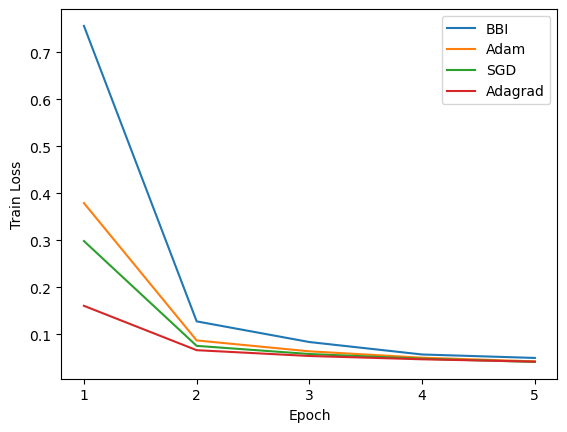

In [52]:
#PLot train loss

t = np.arange(1, 6)

g = sns.lineplot(y=trainloss_bbi, x=t, label='BBI')
sns.lineplot(y=trainloss_adam, x=t, label='Adam')
sns.lineplot(y=trainloss_sgd, x=t, label='SGD')
sns.lineplot(y=trainloss_adagrad, x=t, label='Adagrad')
g.set(xticks=list(range(1,6)))
plt.xlabel('Epoch')
plt.ylabel('Train Loss')

plt.legend()
plt.show()

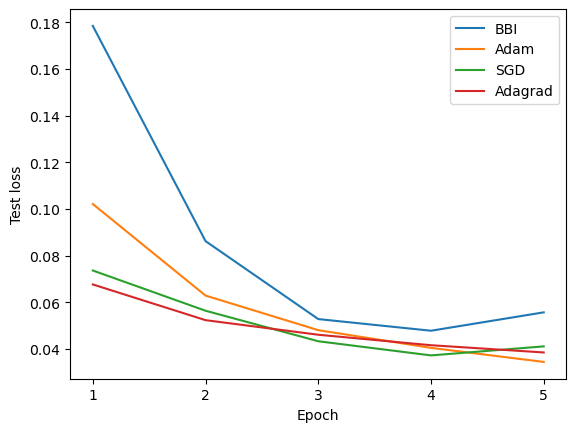

In [54]:
# Plot test loss
t = np.arange(1, 6, 1)

g = sns.lineplot(y=testloss_bbi, x=t, label='BBI')
sns.lineplot(y=testloss_adam, x=t, label='Adam')
sns.lineplot(y=testloss_sgd, x=t, label='SGD')
sns.lineplot(y=testloss_adagrad, x=t, label='Adagrad')
g.set(xticks=list(range(1,6)))
# plt.title('Three Lines Plot')
plt.xlabel('Epoch')
plt.ylabel('Test loss')

plt.legend()
plt.show()

Looking at plots above, we can make several conclusions:
1) The performance of BBI is not far away from other famous optimizers, however both on train and test set it is a little worse than others.
2) Looking at the test plot, we observe that BBI can be not monotone, similar to SGD. We can assume that it's the property of the method, or it stated to overfit at epoch 4.